# Experiments implementing neural networks by hand

In [19]:
import numpy as np
from numpy import random as rnd
from pyclugen import clugen
import matplotlib.pyplot as plt
import keras
from mynn import *
import tensorflow as tf

## Create train and test data with pyclugen

Text(0.5, 0.92, 'Test data')

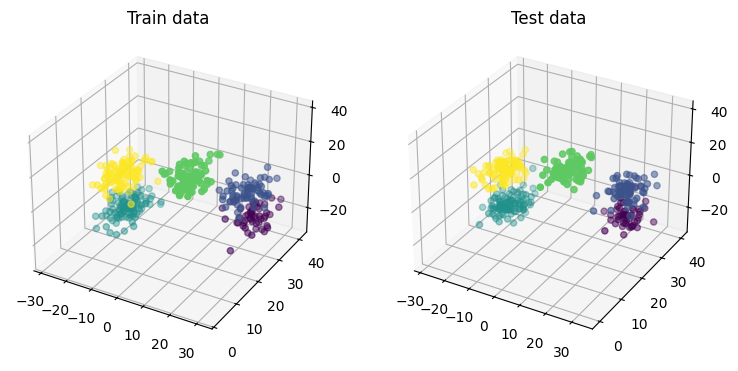

In [20]:
# Clugen parameters
ndims = 3
seed = 123
nclu = 5
npts = 400
direction = [1, 1, 0.5]
angstd = np.pi / 4
csep = [15, 15, 15]
llen = 0.1
llen_std = 0
fat = 3.5

# Generate train data
data_train = clugen(
    ndims,
    nclu,
    npts,
    direction,
    angstd,
    csep,
    llen,
    llen_std,
    fat,
    point_dist_fn="n",
    rng=rnd.default_rng(seed),
)

# Generate test data, based on parameters from train data
data_test = clugen(
    ndims,
    nclu,
    npts * 2,
    data_train.directions,  # Use final directions in the train data
    angstd,
    csep,
    llen,
    llen_std,
    fat,
    point_dist_fn="n",
    rng=rnd.default_rng(seed * 9 - 27),
    # Use final values from the train data
    clusizes_fn=data_train.sizes,
    clucenters_fn=data_train.centers,
    llengths_fn=data_train.lengths,
)

# Plot the train and test data
_, axs = plt.subplots(1, 2, figsize=(9, 6), subplot_kw=dict(projection="3d"))
axs[0].scatter(
    data_train.points[:, 0],
    data_train.points[:, 1],
    data_train.points[:, 2],
    c=data_train.clusters,
)
axs[0].set_title("Train data")
axs[1].scatter(
    data_test.points[:, 0],
    data_test.points[:, 1],
    data_test.points[:, 2],
    c=data_test.clusters,
)
axs[1].set_title("Test data")

## Experiments

In [21]:
# Value that output nodes are expected to have when activated or otherwise
# assuming 1-of-n output encoding
node_off = 0.1
node_on = 0.9

# Convert output to appropriate NN format output
clunn_train, _ = categ2oneofn(data_train.clusters, node_off, node_on)
clunn_test, _ = categ2oneofn(data_test.clusters, node_off, node_on)

### Compare myNN with Keras

In [22]:
# Backpropagation parameters
epochs = 100
eta = 0.05
mom = 0.15
topol = [ndims, 6, nclu]

In [23]:
########
# MyNN #
########

# Prepare hooks for registering accuracy
fitreg_mynn = AccuracyRegister(
    data_train.points, clunn_train, epochs, node_off, node_on
)

# Test vectorized backpropagation
mynn = vbackpropagation(
    data_train.points, clunn_train, topol, epochs, eta, mom, hooks=[fitreg_mynn]
)

In [24]:

#########
# Keras #
#########

# Weight initializer
unif_winit = keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=123)

# Using Sequential() to build layers one after another
model = keras.Sequential()

# Add input layer
model.add(keras.layers.Input(shape=(ndims,)))

# Add hidden layers
for l in range(1, len(topol) - 1):
    model.add(keras.layers.Dense(
            units=topol[l],
            activation="sigmoid",
            kernel_initializer=unif_winit,
            bias_initializer=unif_winit,
        ))

# Add output layer
model.add(keras.layers.Dense(
            units=nclu,
            activation="sigmoid",
            kernel_initializer=unif_winit,
            bias_initializer=unif_winit,
        ))

def sse_half_loss(y_true, y_pred):
    return 0.5 * tf.reduce_sum(tf.square(y_true - y_pred), axis=1)  # per-sample

model.compile(
    loss=sse_half_loss, #keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE),
    optimizer=keras.optimizers.SGD(learning_rate=eta, momentum=mom),
    metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.MeanSquaredError()],
)

history = model.fit(
    x=data_train.points,
    y=clunn_train,
    epochs=epochs,
    batch_size=1,
    shuffle=False,
)

Epoch 1/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 932us/step - categorical_accuracy: 0.7025 - loss: 0.1797 - mean_squared_error: 0.0719
Epoch 2/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - categorical_accuracy: 0.7325 - loss: 0.1504 - mean_squared_error: 0.0602
Epoch 3/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - categorical_accuracy: 0.8275 - loss: 0.1181 - mean_squared_error: 0.0473
Epoch 4/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - categorical_accuracy: 0.8800 - loss: 0.0944 - mean_squared_error: 0.0378
Epoch 5/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - categorical_accuracy: 0.9300 - loss: 0.0745 - mean_squared_error: 0.0298
Epoch 6/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - categorical_accuracy: 0.9450 - loss: 0.0604 - mean_squared_error: 0.0242
Epoch 7/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - categorical_accuracy: 0.9650 - loss: 0.0507 - mean_squared_error: 0.0203
Epoch 8/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - categorical_accuracy: 0.9725 - lo

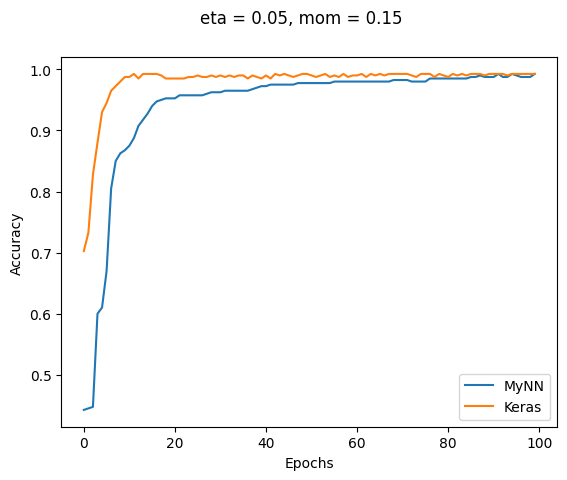

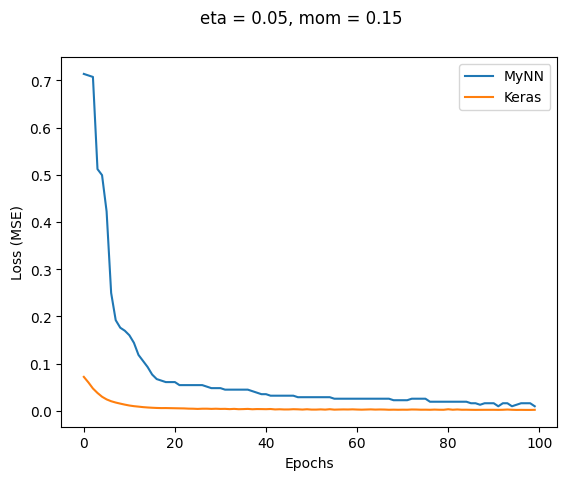

In [25]:
# Plot accuracy
plot_metric(
    epochs,
    {
        "MyNN": fitreg_mynn.accuracies,
        "Keras": history.history['categorical_accuracy'],
    },
    "Accuracy",
    f"eta = {eta}, mom = {mom}",
)

plot_metric(
    epochs,
    {
        "MyNN": fitreg_mynn.losses,
        "Keras": history.history['mean_squared_error'],
    },
    "Loss (MSE)",
    f"eta = {eta}, mom = {mom}",
)

In [26]:
mynn

[array([[ 0.11943237, -0.04015195, -0.07952373, -0.03109055, -0.0271274 ,
          0.05517558],
        [-0.0630903 , -0.33621178,  0.41240507,  0.36092076, -0.03620722,
         -0.15185496],
        [ 0.34849413,  0.0328472 , -0.03126393,  0.00818301,  0.30938571,
         -0.00890754],
        [ 1.0086397 , -0.06758585, -0.74249963,  0.04815103, -0.30453235,
          0.09864397]]),
 array([[ 0.04157458, -3.0100033 , -1.0661149 ,  0.77695378, -1.05457964],
        [-3.47201209,  3.30291971, -2.17985035,  0.26856498,  1.04610006],
        [-1.50759504, -1.50449166,  1.12382753, -0.57711801,  1.06634945],
        [-0.09261555,  2.14248001,  2.26972279, -1.52650146, -3.23634197],
        [ 1.5670444 , -1.51204699, -2.03758657,  1.01299967, -2.19440816],
        [ 0.07962588,  0.96856728, -1.01706248, -2.53807654,  0.92441084],
        [-0.96780112, -1.89779225,  1.07702068, -0.01688076,  0.24400469]])]

In [27]:
model.weights

[<Variable path=sequential_2/dense_4/kernel, shape=(3, 6), dtype=float32, value=[[ 0.46429285 -0.17349249  0.580978   -0.05206709 -0.9477282  -0.5154452 ]
  [-0.00970009  0.6787508  -0.03443864  0.40966707  0.3217348  -0.9127804 ]
  [ 0.04606311  1.8586683  -1.0319325  -0.41951874 -1.7189811  -1.2110506 ]]>,
 <Variable path=sequential_2/dense_4/bias, shape=(6,), dtype=float32, value=[-0.00354013  0.14357404 -0.1353666  -0.01831916 -0.12507199 -0.17358656]>,
 <Variable path=sequential_2/dense_5/kernel, shape=(6, 5), dtype=float32, value=[[ 1.5054007  -0.7548312  -1.5964425   1.1978204  -2.0590608 ]
  [-2.6979015   1.2549872  -0.69270915  0.0220634   0.6289538 ]
  [-0.20855932  2.3364568   1.2775465  -1.3364689  -1.8783952 ]
  [ 0.14053866  1.8074675  -0.8905501  -2.5345383   1.4868652 ]
  [ 1.3481635  -2.6681778  -0.5449552  -0.29183775  0.829956  ]
  [-2.4567852  -1.0842003   2.3950977   0.43369052 -1.9182999 ]]>,
 <Variable path=sequential_2/dense_5/bias, shape=(5,), dtype=float32, va